#Callback Keras

- ModelCheckpoint
- BackupAndRestore
- EarlyStopping
- CSVLogger

##ModelCheckpoint

- Salva o modelo em intervalos regulares (ex.: melhor epoch ou a cada epoch).

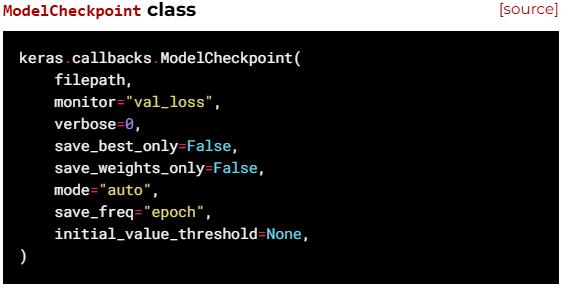




### 📦 Parâmetros de `keras.callbacks.ModelCheckpoint`

| **Parâmetro**              | **Descrição curta**                                                                 |
|---------------------------|--------------------------------------------------------------------------------------|
| `filepath`                | Caminho para salvar o modelo (pode usar `{epoch}`, `{val_loss}` etc).               |
| `monitor`                 | Métrica a ser monitorada (ex: `"val_loss"` ou `"val_accuracy"`).                   |
| `verbose`                 | `0` (silencioso) ou `1` (exibe quando salvar).                                     |
| `save_best_only`          | `True`: salva só o melhor modelo; `False`: salva sempre.                           |
| `save_weights_only`       | `True`: salva só os pesos; `False`: salva o modelo completo.                       |
| `mode`                    | `"auto"`, `"min"` ou `"max"` (define se menor ou maior valor é melhor).            |
| `save_freq`               | `"epoch"` ou número de batches (ex: `500`).                                        |
| `initial_value_threshold`| Só salva se a métrica ultrapassar esse valor (ex: `acc > 0.8`).   


In [ ]:
# Configuração do modelo para treinamento
model.compile(loss=..., optimizer=...,  # Define a função de perda e o otimizador
              metrics=['accuracy'])     # Usa acurácia como métrica de avaliação

EPOCHS = 10  # Número de épocas de treinamento

# Callback para salvar o MELHOR modelo completo durante o treinamento
checkpoint_filepath = '/tmp/ckpt/checkpoint.model.keras'
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,  # Caminho onde o modelo será salvo
    monitor='val_accuracy',        # Monitora a acurácia de validação
    mode='max',                   # Objetivo é maximizar a métrica monitorada
    save_best_only=True)          # Salva apenas se for o melhor até o momento

# Treina o modelo (salva no final de cada época se for o melhor)
model.fit(epochs=EPOCHS, callbacks=[model_checkpoint_callback])

# Como carregar o melhor modelo salvo
keras.models.load_model(checkpoint_filepath)

# --------------------------------------------------------------------------
# Alternativa: Salvar apenas os PESOS do modelo (não a arquitetura completa)
checkpoint_filepath = '/tmp/ckpt/checkpoint.weights.h5'
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,       # Salva apenas os pesos (não o modelo inteiro)
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

# Treina o modelo (salva pesos no final de cada época se for o melhor)
model.fit(epochs=EPOCHS, callbacks=[model_checkpoint_callback])

# Como carregar os melhores pesos salvos
model.load_weights(checkpoint_filepath)

##BackupAndRestore
- Faz backup do modelo e restaura em caso de interrupção (útil para treinos longos).

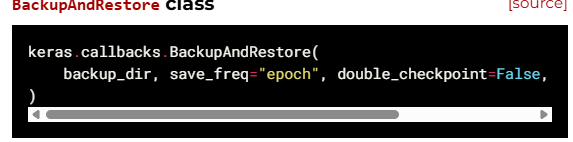

In [ ]:
# Cria um callback personalizado que interrompe o treinamento na época 4
class InterruptingCallback(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs=None):
        if epoch == 4:  # Quando chegar na época 4 (começando de 0)
            raise RuntimeError('Interrupting!')  # Força uma interrupção

# Cria um callback de Backup e Restauração para recuperar o treinamento
callback = keras.callbacks.BackupAndRestore(backup_dir="/tmp/backup")

# Cria um modelo sequencial simples
model = keras.models.Sequential([keras.layers.Dense(10)])
model.compile(keras.optimizers.SGD(), loss='mse')  # Compila com SGD e MSE
model.build(input_shape=(None, 20))  # Define o formato de entrada

# Primeira tentativa de treinamento (será interrompida)
try:
    model.fit(
        np.arange(100).reshape(5, 20),  # Dados de entrada
        np.zeros(5),                    # Targets
        epochs=10,
        batch_size=1,
        callbacks=[callback, InterruptingCallback()],  # Usa ambos callbacks
        verbose=0  # Silencia o output
    )
except:
    pass  # Captura a interrupção proposital

# Segunda tentativa de treinamento (continua de onde parou)
history = model.fit(
    np.arange(100).reshape(5, 20),
    np.zeros(5),
    epochs=10,
    batch_size=1,
    callbacks=[callback],  # Agora só com o callback de backup
    verbose=0
)

# Resultado:
# - O primeiro treino rodou até a época 4 (índice 4 = 5ª época)
# - O segundo treino continuou da época 4 até 9 (mais 6 épocas)
len(history.history['loss'])  # Retornará 6 (as épocas complementares)

##EarlyStopping
- Interrompe o treinamento quando uma métrica (ex.: val_loss) para de melhorar

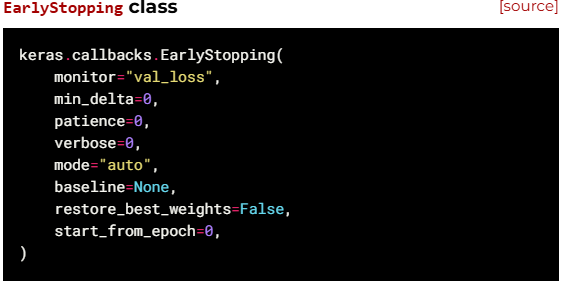

In [ ]:
# Cria um callback de EarlyStopping (Parada Antecipada)
callback = keras.callbacks.EarlyStopping(
    monitor='loss',     # Monitora a perda (loss) do treinamento
    patience=3         # Paciência de 3 épocas (espera 3 épocas sem melhoria)
)

# Funcionamento:
# Este callback irá parar o treinamento automaticamente quando não houver
# melhoria na perda (loss) por 3 épocas consecutivas

# Cria um modelo sequencial simples
model = keras.models.Sequential([keras.layers.Dense(10)])
model.compile(keras.optimizers.SGD(), loss='mse')  # Compila com SGD e MSE

# Executa o treinamento
history = model.fit(
    np.arange(100).reshape(5, 20),  # Dados de entrada (5 amostras de 20 features)
    np.zeros(5),                    # Targets (todos zeros)
    epochs=10,                      # Máximo de 10 épocas
    batch_size=1,                   # 1 amostra por batch
    callbacks=[callback],           # Usa o EarlyStopping
    verbose=0                       # Silencia o output
)

# Resultado:
# O treinamento será interrompido antes das 10 épocas se a loss não melhorar
# Neste caso específico, só completou 4 épocas
len(history.history['loss'])  # Retorna 4 (épocas executadas)

## CSVLogger
- Salva métricas de treinamento em um arquivo CSV.

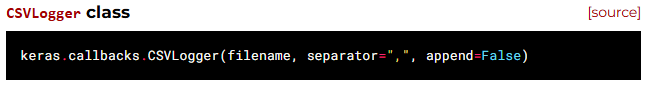

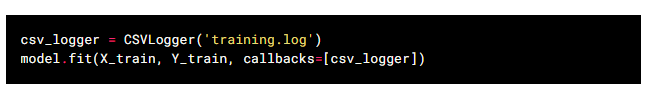

#Codigo CSVLOGGER

In [ ]:
# %% 1. Importações e configuração inicial
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import CSVLogger
from sklearn.model_selection import train_test_split

np.random.seed(42)  # Para reprodutibilidade

In [ ]:
# %% 2. Criação dos dados de exemplo
X = np.random.rand(1000, 10)  # 1000 amostras, 10 características
y = np.random.randint(0, 2, size=(1000,))  # Classificação binária

# Dividir em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Formato X_train: {X_train.shape}")
print(f"Formato y_train: {y_train.shape}")
print(f"Formato X_test: {X_test.shape}")
print(f"Formato y_test: {y_test.shape}")

Formato X_train: (800, 10)
Formato y_train: (800,)
Formato X_test: (200, 10)
Formato y_test: (200,)


In [ ]:
# %% 3. Construção do modelo
model = Sequential([
    Dense(64, activation='relu', input_shape=(10,)),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')  # Saída binária
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()  # Mostra a arquitetura do modelo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,817 (11.00 KB)

 Trainable params: 2,817 (11.00 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# %% 4. Configuração do CSVLogger
csv_logger = CSVLogger(
    'training_log.csv',  # Nome do arquivo de saída
    separator=',',       # Separador de colunas
    append=False         # Sobrescrever arquivo existente
)

In [ ]:
# %% 5. Treinamento do modelo
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[csv_logger],
    verbose=1
)

Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.5133 - loss: 0.6917 - val_accuracy: 0.5200 - val_loss: 0.6938
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5438 - loss: 0.6876 - val_accuracy: 0.5100 - val_loss: 0.6923
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5545 - loss: 0.6870 - val_accuracy: 0.5100 - val_loss: 0.6916
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5069 - loss: 0.6907 - val_accuracy: 0.5200 - val_loss: 0.6918
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5589 - loss: 0.6862 - val_accuracy: 0.5450 - val_loss: 0.6912
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5852 - loss: 0.6803 - val_accuracy: 0.5100 - val_loss: 0.6908
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5680 - loss: 0.6817 - val_accuracy: 0.5000 - val_loss: 0.6898
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5710 - loss: 0.6784 - val_accuracy: 0.5150 - val_los

In [ ]:
# %% 6. Avaliação do modelo
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print("\nResultados finais:")
print(f"Loss no teste: {loss:.4f}")
print(f"Acurácia no teste: {accuracy:.4f}")


Resultados finais:
Loss no teste: 0.6884
Acurácia no teste: 0.5200
